# Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)


# 读取TF 配置, 防止出现BLAS错误

config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# 显示变量的位置是否在GPU
#tf.debugging.set_log_device_placement(True)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# 获取数据

In [2]:
#csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
csv_path = "BTC-USD.csv"
df = pd.read_csv(csv_path, parse_dates=['Date'])
df = df.sort_values('Date')

In [3]:
df.shape

(3201, 7)

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


# Timer Series 特性
1. stationarity (平稳性)
2. seasonality (季节性)
3. autocorrelation (自相关性)

## Time Series forecasting

## RNN
Recurrent Neural Networks

-  allow using the output from the model as a new input for the same model
-  Long short-term memory (LSTM), 处理长时间相关性

# 显示数据

Text(0, 0.5, 'Close Price (USD)')

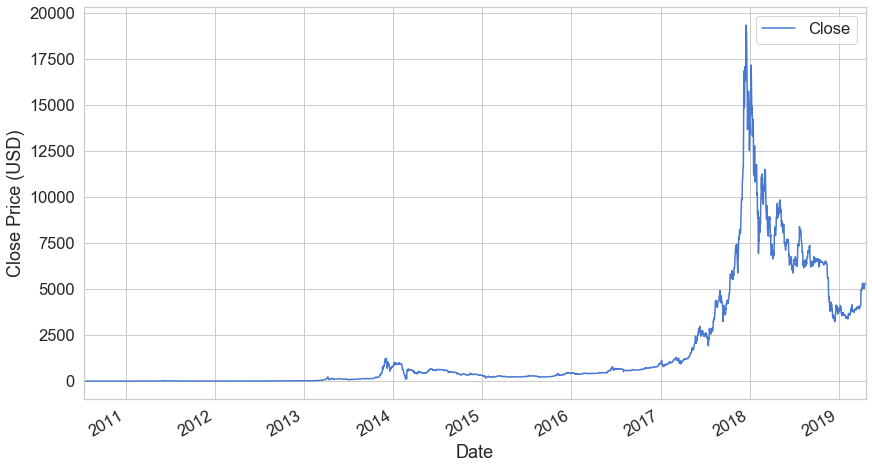

In [5]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [6]:
scaler = MinMaxScaler()
print(df.Close.values.shape)
close_price = df.Close.values.reshape(-1, 1)
print(close_price.shape)
scaled_close = scaler.fit_transform(close_price)
print(scaled_close.shape)

(3201,)
(3201, 1)
(3201, 1)


In [7]:
np.isnan(scaled_close).any()

False

In [8]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)
np.isnan(scaled_close).any()

False

# Preprocessing

In [9]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [10]:
print(scaled_close.shape)
print(X_train.shape)

(3201, 1)
(2945, 99, 1)


In [11]:
print(scaled_close[0:10])

[[0.00000000e+00]
 [1.87796187e-06]
 [1.61743537e-06]
 [1.30418326e-06]
 [1.53524546e-06]
 [5.11748486e-08]
 [6.77679056e-07]
 [2.60009584e-07]
 [5.11748486e-08]
 [3.35479563e-07]]


In [12]:
print(X_train[1][0:10])

[[1.87796187e-06]
 [1.61743537e-06]
 [1.30418326e-06]
 [1.53524546e-06]
 [5.11748486e-08]
 [6.77679056e-07]
 [2.60009584e-07]
 [5.11748486e-08]
 [3.35479563e-07]
 [5.42246628e-07]]


# Model

In [13]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [14]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [15]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Train on 2650 samples, validate on 295 samples
Epoch 1/10
2650/2650 [==============================] - 23s 9ms/sample - loss: 0.0011 - val_loss: 0.0554
Epoch 2/10
2650/2650 [==============================] - 2s 845us/sample - loss: 0.0072 - val_loss: 0.0258
Epoch 3/10
2650/2650 [==============================] - 2s 826us/sample - loss: 0.0041 - val_loss: 0.0143
Epoch 4/10
2650/2650 [==============================] - 2s 828us/sample - loss: 5.0057e-04 - val_loss: 0.0016
Epoch 5/10
2650/2650 [==============================] - 2s 823us/sample - loss: 0.0096 - val_loss: 0.0170
Epoch 6/10
2650/2650 [==============================] - 2s 829us/sample - loss: 0.0032 - val_loss: 0.0093
Epoch 7/10
2650/2650 [==============================] - 2s 828us/sample - loss: 0.0129 - val_loss: 0.0073
Epoch 8/10
2650/2650 [==============================] - 2s 830us/sample - loss: 0.0108 - val_loss: 0.0014
Epoch 9/10
2650/2650 [==============================] - 2s 827us/sample - loss: 0.0079 - val_loss: 0.0

In [16]:
model.evaluate(X_test, y_test)

156/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.012689823332505349

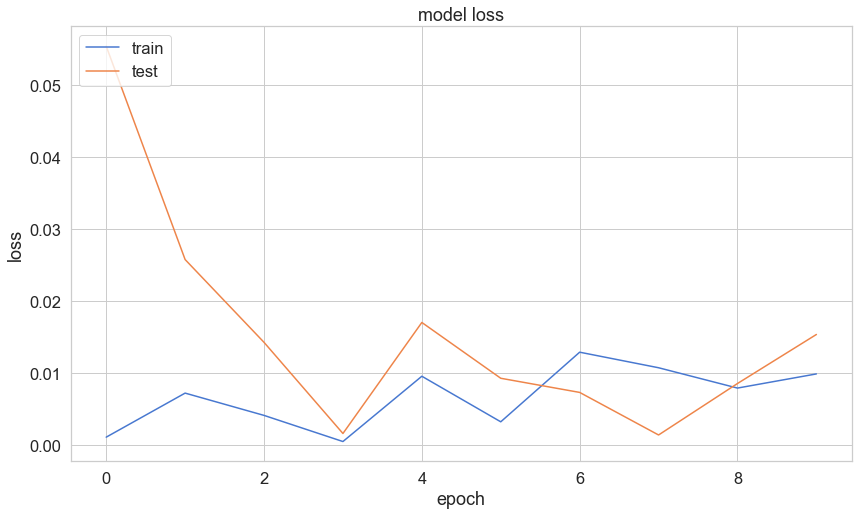

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predict

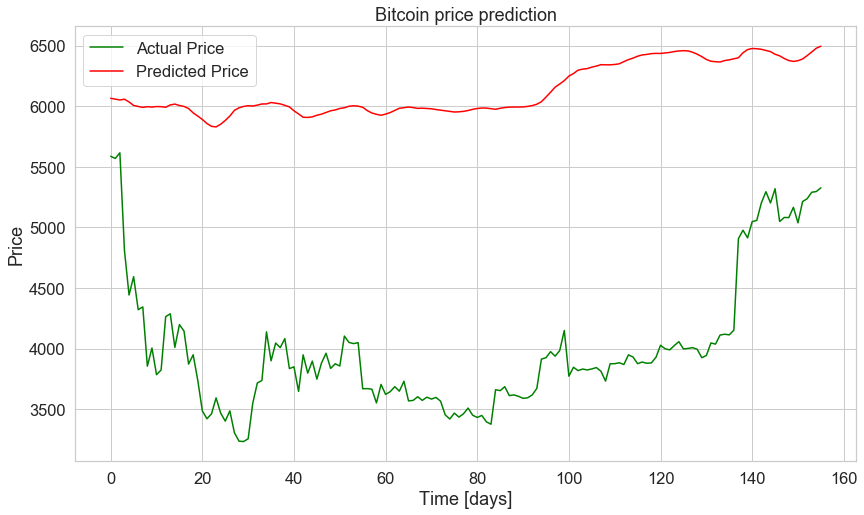

In [18]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();